# Литература
* [Стратификация. Как разбиение выборки повышает чувствительность A/B теста](https://habr.com/ru/companies/X5Tech/articles/596279/)
* [Статья NETFLIX (eng)](https://www.researchgate.net/publication/305997925_Improving_the_Sensitivity_of_Online_Controlled_Experiments_Case_Studies_at_Netflix)
* [Как улучшить ваши A/B-тесты: лайфхаки аналитиков Авито. Часть 2](https://habr.com/ru/companies/avito/articles/571096/)

<p align="center">
  <img width="1560" height="1055" src="https://habrastorage.org/r/w1560/getpro/habr/upload_files/e8a/5c7/573/e8a5c7573b76a117e4555288df5d9e34.png">
</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats

sns.set_theme(context='notebook', 
                  style='darkgrid', 
                  palette='deep',
                  font='sans-serif', 
                  font_scale=1, 
                  color_codes=True, 
                  rc=None)

# Генерация данных

In [2]:
def generate_random_data(mean_one, mean_two, std_one, std_two, sample_size):
    '''
    Генерируется выборка размером sample_size со случайной долей страт

    Для простоты собирается выборка из двух нормальных распределений
    размера sample_size * 2, затем сэмплируется итоговая выборка 
    размера sample_size

    '''
    d_one = {'strat': 0,
             'metric': np.random.normal(loc=mean_one, scale=std_one, size=5000)}
    d_two = {'strat': 1,
             'metric': np.random.normal(loc=mean_two, scale=std_two, size=5000)}

    df_one = pd.DataFrame(d_one)
    df_two = pd.DataFrame(d_two)
    df = pd.concat([df_one, df_two], ignore_index=True).sample(sample_size, replace=False)
    return df

In [3]:
def generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size):
    '''
    Генерируется выборка размером sample_size с постоянной долей страт

    Для простоты собирается выборка из двух нормальных распределений
    с долей страт 0.5/0.5

    '''
    size_strata_one = int(sample_size / 2)
    size_strata_two = sample_size - size_strata_one
    
    d_one = {'strat': 0,
             'metric': np.random.normal(loc=mean_one, scale=std_one, size=size_strata_one)}
    d_two = {'strat': 1,
             'metric': np.random.normal(loc=mean_two, scale=std_two, size=size_strata_two)}
    
    df_one = pd.DataFrame(d_one)
    df_two = pd.DataFrame(d_two)
    
    df = pd.concat([df_one, df_two], ignore_index=True)
    return df

In [4]:
def calculate_mean(df):
    '''
    Функция вычисляет обычное среднее    
    
    '''
    
    return np.mean(df['metric'])

In [5]:
def calculate_stratified_mean(df, weights):
    '''
    Функция вычисляет стратифицированное среднее
    
    '''
                              
    strat_mean = df.groupby('strat')['metric'].mean()
    
    df_means_weights = pd.merge(
                        strat_mean,
                        pd.Series(weights, name='weight'),
                        how='inner',
                        left_index=True,
                        right_index=True)
#    Что если в выборку не попали некоторые страты?    
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights['metric']).sum()
    return mean_strat

In [6]:
alpha = 0.05
sample_size = 1100
mean_one = 2000
mean_two = 3000
std_one = 625
std_two = 625

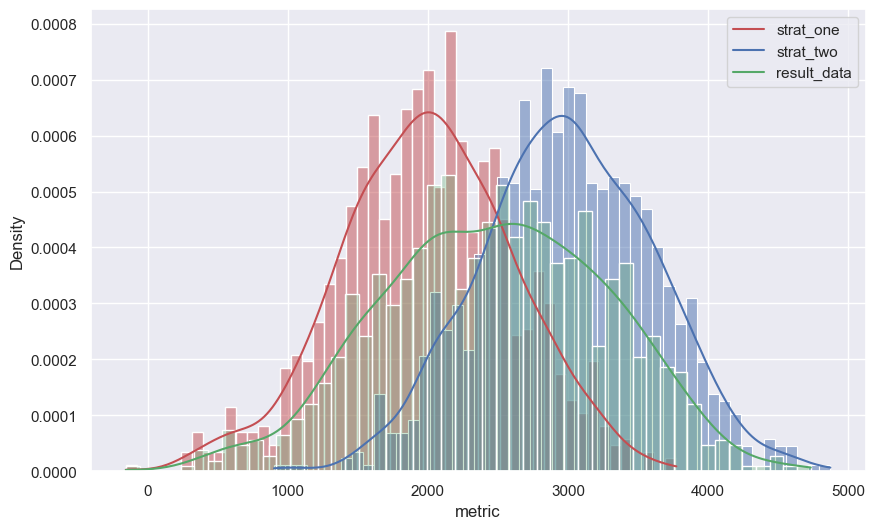

In [7]:
# Пример данных
strat_one = np.random.normal(loc=mean_one, scale=std_one, size=sample_size)
strat_two = np.random.normal(loc=mean_two, scale=std_two, size=sample_size)
result_data = np.random.choice(np.hstack([strat_one, strat_two]), size = sample_size, replace=False) 

plt.figure(figsize=(10, 6))
sns.histplot(x=strat_one, color="r", alpha=0.5, bins=50, stat='density', kde=True)
sns.histplot(x=strat_two, color="b", alpha=0.5, bins=50, stat='density', kde=True)
sns.histplot(x=result_data, color="g", alpha=0.3, bins=50, stat='density', kde=True)

plt.xlabel('metric')
plt.legend(labels=['strat_one','strat_two', 'result_data'])
plt.show()

In [8]:
random_deltas = []
stratified_deltas = []
for _ in range(10000):
    a_one_random = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size) 
    a_two_random = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size)
    random_deltas.append(np.mean(a_one_random['metric']) - np.mean(a_two_random['metric']))
    
    a_one_stratified = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size) 
    a_two_stratified = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size)
    stratified_deltas.append(np.mean(a_one_stratified['metric']) - np.mean(a_two_stratified['metric']))

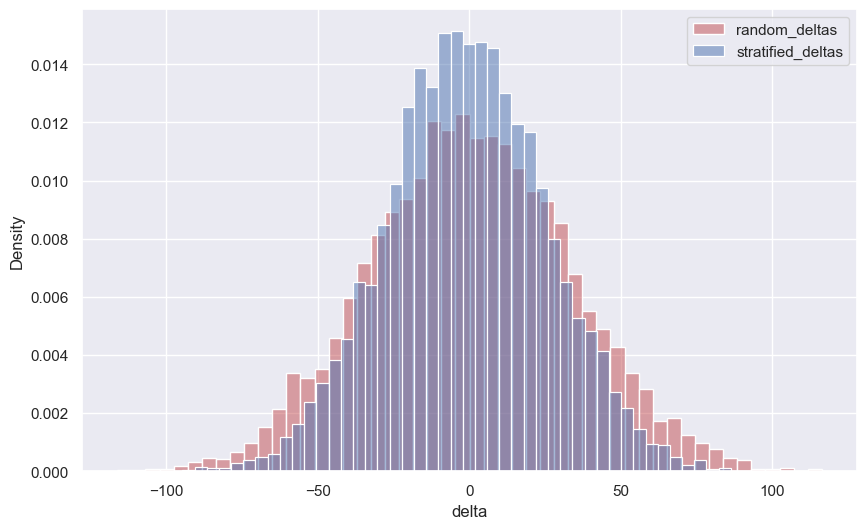

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(x=random_deltas, color="r", alpha=0.5, bins=50, stat='density', label='random_deltas')
sns.histplot(x=stratified_deltas, color="b", alpha=0.5, bins=50, stat='density', label='stratified_deltas')
plt.xlabel('delta')
plt.legend()
plt.show()

In [10]:
random_means = []
stratified_means = []
weights = {0: 0.5, 1: 0.5}
for _ in range(10000):
    df_srs = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size) 
    random_means.append(calculate_mean(df_srs))
    
    df_stratified = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size)     
    stratified_means.append(calculate_stratified_mean(df_stratified, weights))

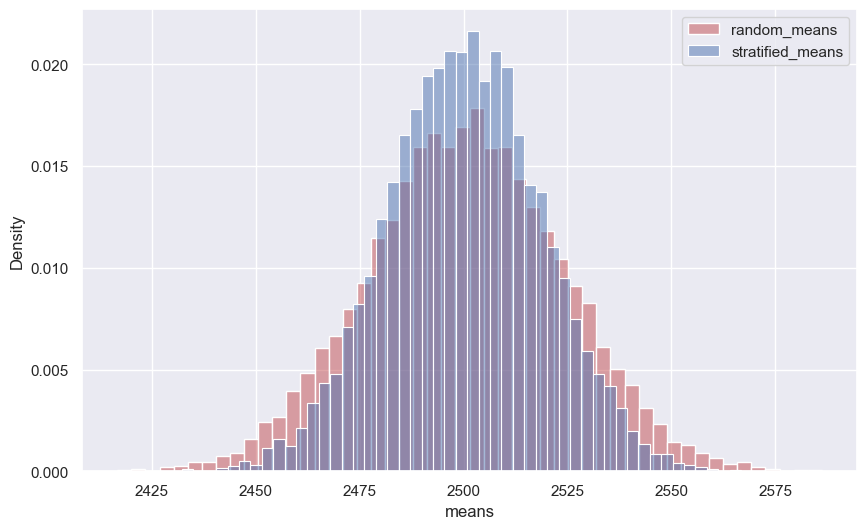

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(x=random_means, color="r", alpha=0.5, bins = 50, stat='density')
sns.histplot(x=stratified_means, color="b", alpha=0.5, bins = 50, stat='density')
plt.xlabel('means')
plt.legend(labels=['random_means','stratified_means'])
plt.show()

# Дисперсия

In [12]:
alpha = 0.05
sample_sizes = [500, 1000, 2000, 10000]
mean_one = 2000
mean_two = 3000
std_one = 625
std_two = 625

In [13]:
# Меняем размер групп и смротрим на дисперсию средних при разном формировании выборки

In [14]:
random_vars = []
stratified_vars = []
poststratified_vars = []
weights = {0: 0.5, 1: 0.5}

for sample_size in sample_sizes:
    random_means = []
    poststratified_means = []
    stratified_means = []
    for _ in range(1000):
        df_srs = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size)
        df_stratified = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size)
        
        random_means.append(calculate_mean(df_srs))              
        stratified_means.append(calculate_stratified_mean(df_stratified, weights))
        poststratified_means.append(calculate_stratified_mean(df_srs, weights))
        
    random_vars.append(np.var(random_means))
    stratified_vars.append(np.var(stratified_means))
    poststratified_vars.append(np.var(poststratified_means))

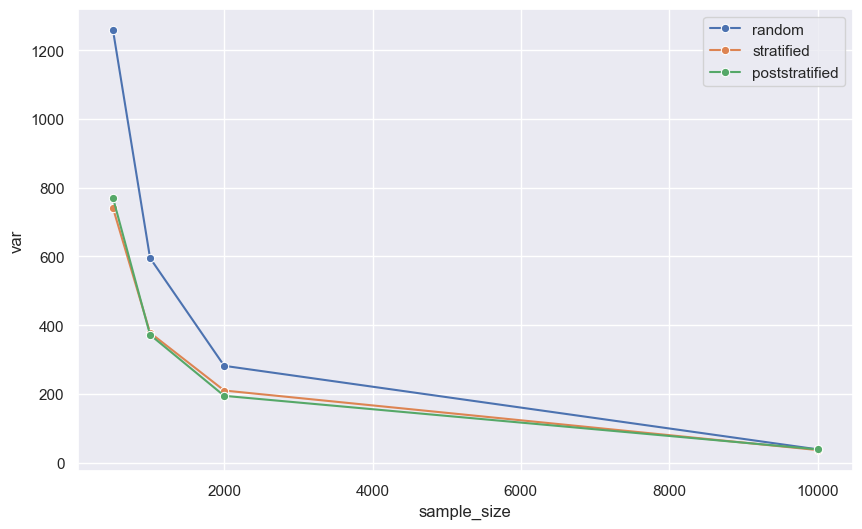

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=sample_sizes, y=random_vars, marker='o', label='random')
sns.lineplot(x=sample_sizes, y=stratified_vars, marker='o', label='stratified')
sns.lineplot(x=sample_sizes, y=poststratified_vars, marker='o', label='poststratified')
plt.xlabel('sample_size')
plt.ylabel('var')
plt.show()

In [16]:
# Меняем разницу средних в стратах и смротрим на дисперсию средних при разном формировании выборки

In [17]:
random_vars = []
stratified_vars = []
poststratified_vars = []
weights = {0: 0.5, 1: 0.5}
sample_size = 1000
effect_sizes = [0, 0.05, 0.10, 0.15, 0.2, 0.3]
mean_one = 2000

std_one = 300
std_two = 300

for effect_size in effect_sizes:
    random_means = []
    poststratified_means = []
    stratified_means = []
    for _ in range(3000):
        df_srs = generate_random_data(mean_one, mean_one * (1 + effect_size), std_one, std_two, sample_size)
        df_stratified = generate_stratified_data(mean_one, mean_one * (1 + effect_size), std_one, std_two, sample_size)
        
        random_means.append(calculate_mean(df_srs))              
        stratified_means.append(calculate_stratified_mean(df_stratified, weights))
        poststratified_means.append(calculate_stratified_mean(df_srs, weights))
        
    random_vars.append(np.var(random_means))
    stratified_vars.append(np.var(stratified_means))
    poststratified_vars.append(np.var(poststratified_means))

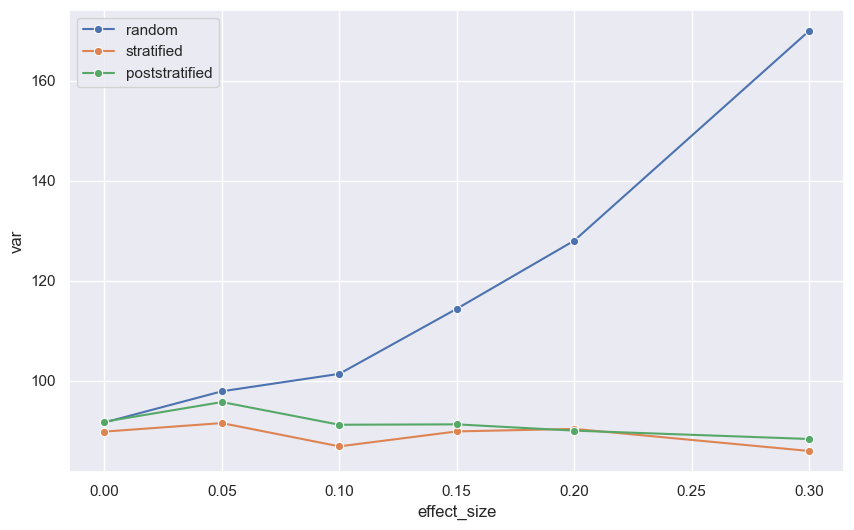

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=effect_sizes, y=random_vars, marker='o', label='random')
sns.lineplot(x=effect_sizes, y=stratified_vars, marker='o', label='stratified')
sns.lineplot(x=effect_sizes, y=poststratified_vars, marker='o', label='poststratified')
plt.xlabel('effect_size')
plt.ylabel('var')
plt.show()

# Оценка экспериментов

In [19]:
def check_test(df_a, df_b, alpha=0.05):
    _, pvalue = stats.ttest_ind(df_a['metric'].values, df_b['metric'].values)
    return pvalue

In [20]:
def calculate_stratified_var(df, weights):
    '''
    Функция вычисляет стратифицированную дисперсию
    
    '''
                              
    strat_var = df.groupby('strat')['metric'].var()
    
    df_var_weights = pd.merge(
                        strat_var,
                        pd.Series(weights, name='weight'),
                        how='inner',
                        left_index=True,
                        right_index=True)
#    Что если в выборку не попали некоторые страты?    
    df_var_weights['weight'] = df_var_weights['weight'] / df_var_weights['weight'].sum()
    var_strat = (df_var_weights['weight'] * df_var_weights['metric']).sum()
    return var_strat

In [21]:
def check_stratified_test(a, b, weights):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    mean_a = calculate_stratified_mean(a, weights)
    mean_b = calculate_stratified_mean(b, weights)
    var_a = calculate_stratified_var(a, weights)
    var_b = calculate_stratified_var(b, weights)
    delta = mean_b - mean_a
    std_mean = (var_b / len(b) + var_a / len(a)) ** 0.5
    t = delta / std_mean
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

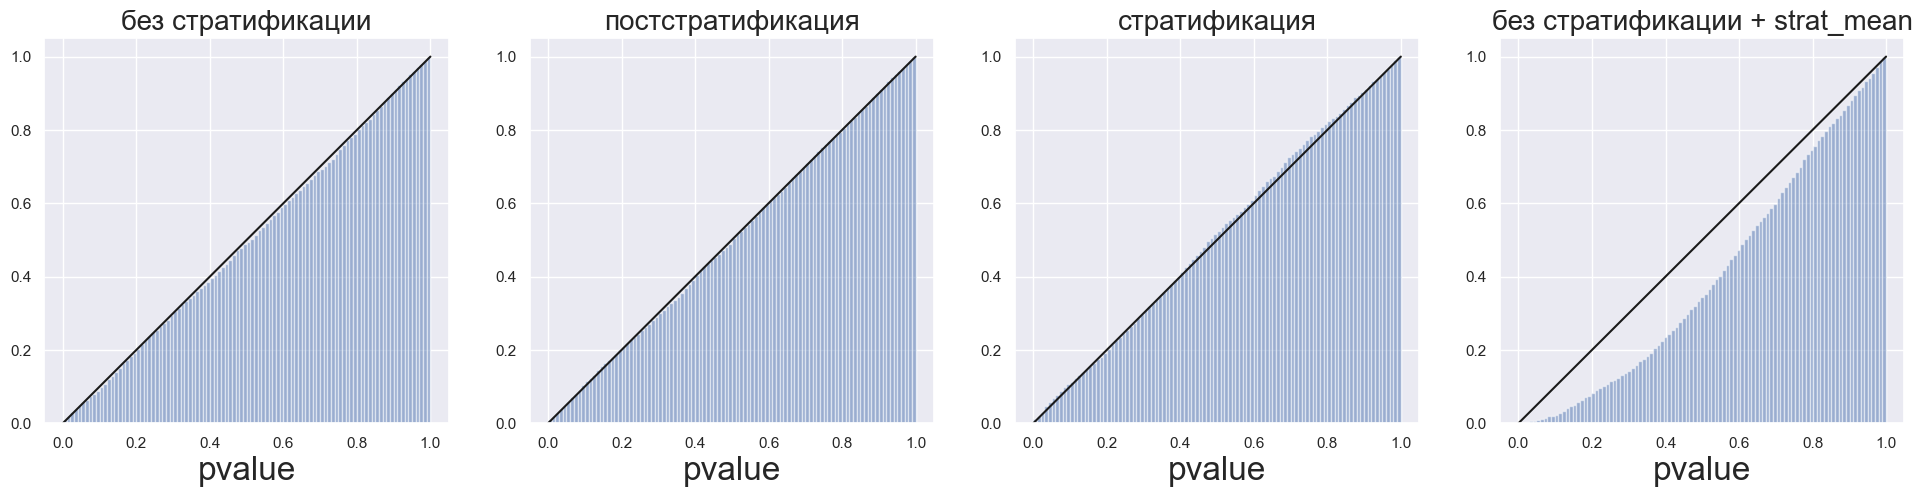

In [22]:
mean_one = 0
mean_two = 2
std_one = 1
std_two = 1
weights = {0: 0.5, 1: 0.5}
sample_size = 1000

pvalues_random = []
pvalues_poststratified = []
pvalues_stratified = []
pvalues_random_strat_mean = []

for _ in range(3000):
    df_srs_one = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size)
    df_srs_two = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size)
    df_stratified_one = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size)
    df_stratified_two = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size)

    pvalues_random.append(check_test(df_srs_one, df_srs_two))
    pvalues_poststratified.append(check_stratified_test(df_srs_one, df_srs_two, weights))
    pvalues_stratified.append(check_stratified_test(df_stratified_one, df_stratified_two, weights))
    pvalues_random_strat_mean.append(check_test(df_stratified_one, df_stratified_two))

_, axes = plt.subplots(1, 4, figsize=[24, 5])
list_pvalues = [pvalues_random, pvalues_poststratified, pvalues_stratified, pvalues_random_strat_mean]
list_titles = ['без стратификации', 'постстратификация', 'стратификация','без стратификации + strat_mean']

for ax, pvalues, title in zip(axes, list_pvalues, list_titles):
    ax.hist(pvalues, bins=100, density=True, cumulative=True, alpha=0.5)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('pvalue', fontsize=24)
    ax.plot([0, 1], [0, 1], 'k')
plt.show()

In [23]:
mean_one = 0
mean_two = 2
std_one = 1
std_two = 1
weights = {0: 0.5, 1: 0.5}
sample_size = 1000

pvalues_random = []
pvalues_poststratified = []
pvalues_stratified = []
pvalues_random_strat_mean = []

for _ in range(3000):
    df_srs_one = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size)
    df_srs_two = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size)
    df_stratified_one = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size)
    df_stratified_two = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size)
#   add eff
    effect = np.random.normal(0.1, 0.05, sample_size)
    df_srs_two['metric'] += effect
    df_stratified_two['metric'] += effect
    
    pvalues_random.append(check_test(df_srs_one, df_srs_two))
    pvalues_poststratified.append(check_stratified_test(df_srs_one, df_srs_two, weights))
    pvalues_stratified.append(check_stratified_test(df_stratified_one, df_stratified_two, weights))
    pvalues_random_strat_mean.append(check_test(df_stratified_one, df_stratified_two))

list_pvalues = [pvalues_random, pvalues_poststratified, pvalues_stratified, pvalues_random_strat_mean]
list_titles = ['без стратификации', 'постстратификация', 'стратификация', 'без стратификации + strat_mean' ]

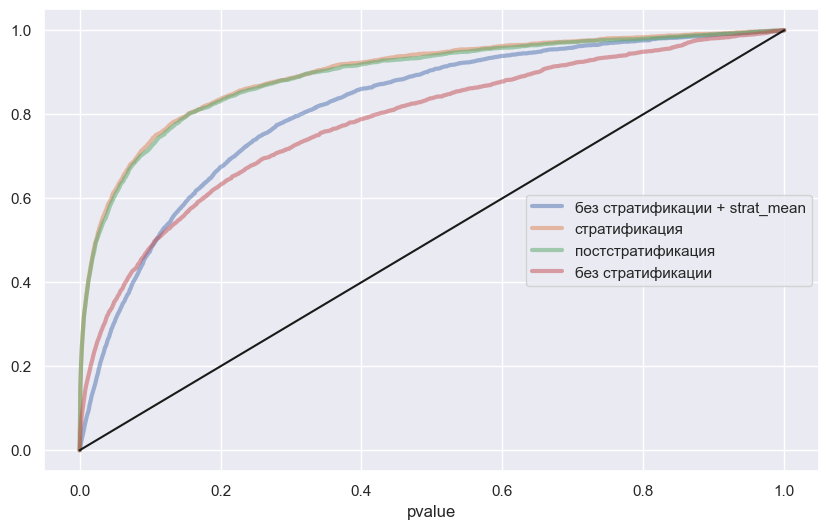

In [24]:
plt.figure(figsize=(10, 6))
X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()